<a id='neural'></a> 
## 7. Neural networks models exploration

In [1]:
import json
import pandas as pd
import numpy as np
import pprint
import time
import pytz
from pandas import datetime
from datetime import datetime, timedelta
#!pip install impyute
# to impute missing values of time series data
import impyute as impy
import itertools

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams  # Dynamic rc settings
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score# to split the data into two parts
from sklearn.preprocessing import OneHotEncoder   # categorical features encoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## for Deep-learing:
import tensorflow as tf
print(tf.__version__)
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

2.0.0-beta1


Using TensorFlow backend.


In [2]:
# load the dataset
tal_final = pd.read_csv("tal_final.csv", parse_dates=True, index_col = 0)

In [33]:
def oneDArray(x):
    return list(itertools.chain(*x))
# equal ## flat = [x for sublist in nested for x in sublist]

In [11]:
# Step 1 :Transform the univariate dataset into a supervised learning problem
# convert time series into supervised learning problem
def series_to_supervised(data,  col_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
     data: Sequence of observations as a list or NumPy array.
     n_in: Number of lag observations as input (X).
     n_out: Number of observations as output (y).
     dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
     Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]   # n_vars: number of variables(feautures), equal to n_features
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))        # shift one step forward
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Deep neural networks has achieved great success recently. DNNs are data-driven and have capability of non-linear modeling, without any presumption about the statistical distribution followed by the observations. To deal with sequence data recurrent neural network (RNN) perform usually pretty well.
### One of the popular model architecture is called Long Short Term Memory(LSTM) which has feedback connection. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. 
### Even though a lot of papers show little success with LSTMs directly for time series prediction. We still give LSTM a try to forecast this time series task. 

Lessons Learned Applying LSTMs for Time Series Forecasting
Taken from “Time-series Extreme Event Forecasting with Neural Networks at Uber” Slides.
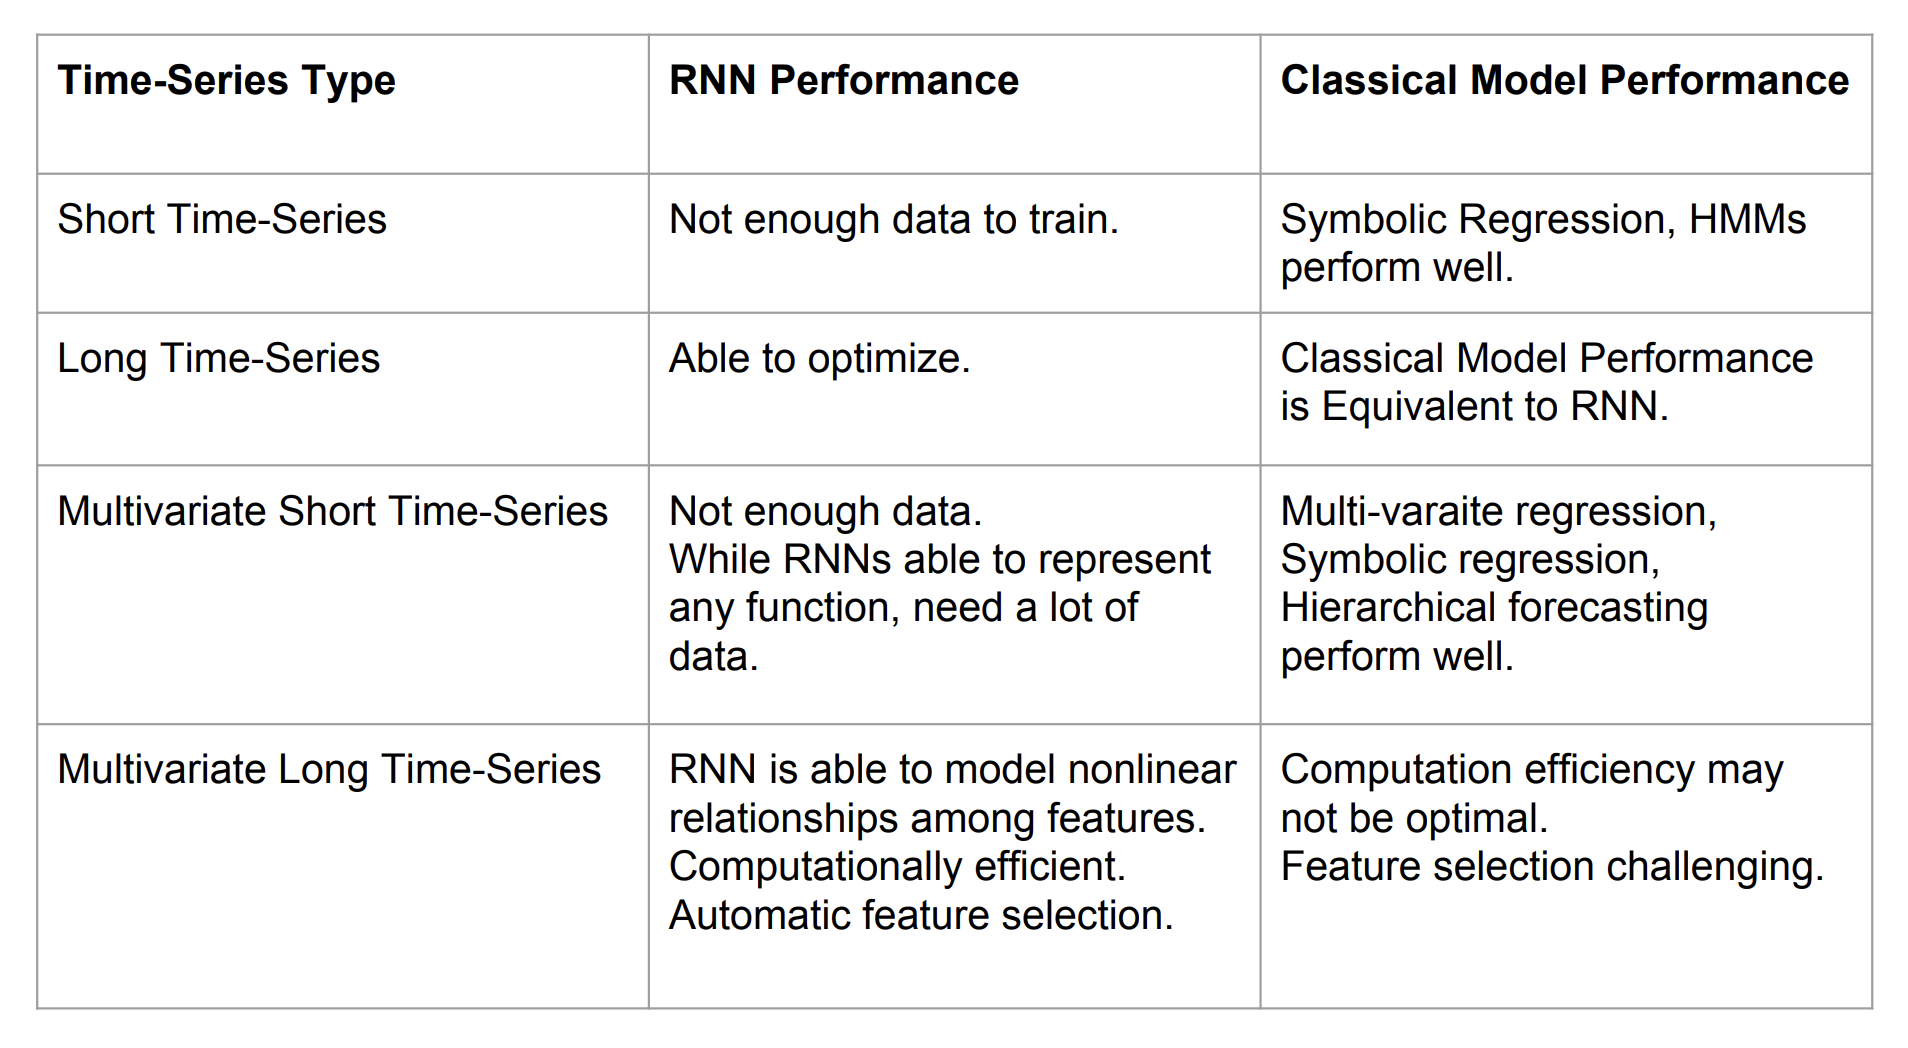

## LSTM 
Several codes are from <a href="https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ " target="_blank">this blog</a> 

<a id='lstm1'></a> 
## 7.1 Part one: Multivariate one-step using a simple LSTM prediction

In [6]:
# load the data
values = tal_final.values
# split into train and test sets
n_test = int(365 * 24 * 1)
train, test = values[:-n_test, :], values[-n_test:, :]

In [16]:
tal_final.head()

,demand,temperature,holiday_1,quarter_2,quarter_3,quarter_4,day_1,day_2,day_3,week_1
2015-07-01 01:00:00,225.0,20.30,0,0,1,0,0,0,0,0
2015-07-01 02:00:00,222.0,19.84,0,0,1,0,0,0,0,0
2015-07-01 03:00:00,213.0,19.80,0,0,1,0,0,0,0,0
2015-07-01 04:00:00,206.0,19.85,0,0,1,0,0,0,0,0
2015-07-01 05:00:00,207.0,19.95,0,0,1,0,0,0,0,0


In [8]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [9]:
train_scaled

array([[0.09634551, 0.6223013 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09136213, 0.6113879 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07641196, 0.61043891, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21760797, 0.68232503, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17774086, 0.67615658, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15448505, 0.6633452 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
# specify the number of lag hours
n_lag = 1
n_features = 10
# frame as supervised learning
train_reframed = series_to_supervised(train_scaled, col_names=tal_final.columns, n_in=n_lag, n_out=1) # series_to_supervised(scaled_values, col_names='demand', n_in=1, n_out=1)
print(train_reframed.shape)

(28874, 20)


In [20]:
train_reframed.head()

,demand(t-1),temperature(t-1),holiday_1(t-1),quarter_2(t-1),quarter_3(t-1),quarter_4(t-1),day_1(t-1),day_2(t-1),day_3(t-1),week_1(t-1),demand(t),temperature(t),holiday_1(t),quarter_2(t),quarter_3(t),quarter_4(t),day_1(t),day_2(t),day_3(t),week_1(t)
1,0.096346,0.622301,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.091362,0.611388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.091362,0.611388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.076412,0.610439,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.076412,0.610439,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.064784,0.611625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.064784,0.611625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.066445,0.613998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.066445,0.613998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.086379,0.626097,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# specify the number of lag hours
n_lag = 1
n_features = 10
# frame as supervised learning
test_reframed = series_to_supervised(test_scaled, col_names=tal_final.columns, n_in=n_lag, n_out=1) # series_to_supervised(scaled_values, col_names='demand', n_in=1, n_out=1)
print(test_reframed.shape)

(8759, 20)


In [22]:
train_lstm = train_reframed.values
test_lstm = test_reframed.values

In [23]:
# split into input and outputs
n_obs = n_lag * n_features
X_train_lstm, y_train_lstm = train_lstm[:, :n_obs], train_lstm[:, -n_features]
X_test_lstm, y_test_lstm = test_lstm[:, :n_obs], test_lstm[:, -n_features]
print(X_train_lstm.shape, len(X_train_lstm), y_train_lstm.shape)

(28874, 10) 28874 (28874,)


In [24]:
# multivariate one_step time forecast
# reshape input to be 3D [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], n_lag, n_features))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], n_lag, n_features))
print(X_train_lstm.shape, y_train_lstm.shape, X_test_lstm.shape, y_test_lstm.shape)

(28874, 1, 10) (28874,) (8759, 1, 10) (8759,)


In [27]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) #input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Train on 28874 samples, validate on 8759 samples
Epoch 1/100
 - 3s - loss: 0.0655 - val_loss: 0.0823
Epoch 2/100
 - 1s - loss: 0.0401 - val_loss: 0.0386
Epoch 3/100
 - 1s - loss: 0.0228 - val_loss: 0.0323
Epoch 4/100
 - 1s - loss: 0.0197 - val_loss: 0.0302
Epoch 5/100
 - 1s - loss: 0.0191 - val_loss: 0.0303
Epoch 6/100
 - 1s - loss: 0.0192 - val_loss: 0.0325
Epoch 7/100
 - 1s - loss: 0.0193 - val_loss: 0.0314
Epoch 8/100
 - 1s - loss: 0.0192 - val_loss: 0.0338
Epoch 9/100
 - 1s - loss: 0.0192 - val_loss: 0.0334
Epoch 10/100
 - 2s - loss: 0.0192 - val_loss: 0.0323
Epoch 11/100
 - 2s - loss: 0.0190 - val_loss: 0.0317
Epoch 12/100
 - 1s - loss: 0.0189 - val_loss: 0.0321
Epoch 13/100
 - 1s - loss: 0.0188 - val_loss: 0.0303
Epoch 14/100
 - 2s - loss: 0.0186 - val_loss: 0.0287
Epoch 15/100
 - 2s - loss: 0.0184 - val_loss: 0.0298
Epoch 16/100
 - 2s - loss: 0.0184 - val_loss: 0.0297
Epoch 17/100
 - 2s - loss: 0.0183 - val_loss: 0.0290
Epoch 18/100
 - 2s - loss: 0.0182 - val_loss: 0.0297
Epoch 

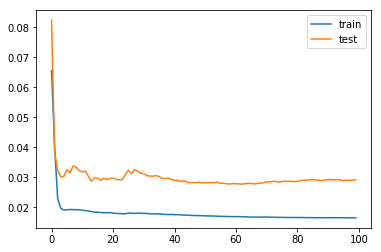

In [28]:
# fit network
history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### From the plot we see both train/test converges. There are some oscillation in the test which might due to the batch size

In [29]:
# make a prediction
yhat_lstm = model.predict(X_test_lstm)
# reshape the dim. 
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], n_lag*n_features))
# invert scaling for forecast
inv_yhat_lstm = np.concatenate((yhat_lstm, X_test_lstm[:, -9:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]
# invert scaling for actual
y_test_lstm = y_test_lstm.reshape((len(y_test_lstm), 1))
inv_y_lstm = np.concatenate((y_test_lstm, X_test_lstm[:, -9:]), axis=1)
inv_y_lstm = scaler.inverse_transform(inv_y_lstm)
inv_y_lstm = inv_y_lstm[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_lstm, inv_yhat_lstm))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.557


## Surprisingly LSTM has really low RMSE value! 

<a id='lstm'></a> 
## 7.2 Part Two: Multivariate multi-steps using a simple LSTM prediction

In [30]:
# load the data
#values = tal_final.values
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_lag = 1
n_features = 10
n_out = 24

In [31]:
# frame as supervised learning
reframed = series_to_supervised(tal_final, col_names=tal_final.columns, n_in=n_lag, n_out=24) # series_to_supervised(scaled_values, col_names='demand', n_in=1, n_out=1)
print(reframed.shape)

(37611, 250)


In [34]:
list_drop = []
# drop columns we don't want to predict
for i in range(1,(n_out+1)):
    list1 = list(range(1+tal_final.shape[1]*(i+n_lag-1),(tal_final.shape[1]*(i+ n_lag))))
    list_drop.append(list1)
    # convert 2D matrix to 1D array
list_drop = oneDArray(list_drop)
reframed.drop(reframed.columns[list_drop], axis=1, inplace=True) 

In [35]:
reframed[:1]

,demand(t-1),temperature(t-1),holiday_1(t-1),quarter_2(t-1),quarter_3(t-1),quarter_4(t-1),day_1(t-1),day_2(t-1),day_3(t-1),week_1(t-1),...,demand(t+14),demand(t+15),demand(t+16),demand(t+17),demand(t+18),demand(t+19),demand(t+20),demand(t+21),demand(t+22),demand(t+23)
2015-07-01 02:00:00,225.0,20.3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,474.0,481.0,480.0,467.0,444.0,425.0,413.0,378.0,340.0,307.0


In [41]:
# load the data
values = reframed.values
# split into train and test sets
n_test = int(365 * 24 * 1)
train, test = values[:-n_test, :], values[-n_test:, :]
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_lstm= scaler.fit_transform(train)
test_lstm = scaler.fit_transform(test)

In [42]:
train_lstm.shape

(28851, 34)

In [43]:
test_lstm.shape

(8760, 34)

In [44]:
n_obs = n_lag * n_features
X_train_lstm, y_train_lstm = train_lstm[:, :n_obs], train_lstm[:, -n_out:]

In [45]:
X_train_lstm.shape

(28851, 10)

In [46]:
y_train_lstm.shape

(28851, 24)

In [47]:
# split into input and outputs
n_obs = n_lag * n_features
X_train_lstm, y_train_lstm = train_lstm[:, :n_obs], train_lstm[:, -n_out:]
X_test_lstm, y_test_lstm = test_lstm[:, :n_obs], test_lstm[:, -n_out:]
print(X_train_lstm.shape, len(X_train_lstm), y_train_lstm.shape)

(28851, 10) 28851 (28851, 24)


In [48]:
# multivariate multi_step time forecast
# reshape input to be 3D [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], n_lag, n_features))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], n_lag, n_features))
print(X_train_lstm.shape, y_train_lstm.shape, X_test_lstm.shape, y_test_lstm.shape)

(28851, 1, 10) (28851, 24) (8760, 1, 10) (8760, 24)


In [49]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) #input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
model.add(Dense(24))
model.compile(loss='mae', optimizer='adam')

In [53]:
# fit network
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 28851 samples, validate on 8760 samples
Epoch 1/50
 - 7s - loss: 0.0478 - val_loss: 0.0873
Epoch 2/50
 - 5s - loss: 0.0480 - val_loss: 0.0872
Epoch 3/50
 - 5s - loss: 0.0480 - val_loss: 0.0872
Epoch 4/50
 - 5s - loss: 0.0480 - val_loss: 0.0872
Epoch 5/50
 - 5s - loss: 0.0480 - val_loss: 0.0873
Epoch 6/50
 - 6s - loss: 0.0480 - val_loss: 0.0873
Epoch 7/50
 - 7s - loss: 0.0480 - val_loss: 0.0873
Epoch 8/50
 - 7s - loss: 0.0480 - val_loss: 0.0874
Epoch 9/50
 - 6s - loss: 0.0480 - val_loss: 0.0874
Epoch 10/50
 - 7s - loss: 0.0480 - val_loss: 0.0875
Epoch 11/50
 - 7s - loss: 0.0480 - val_loss: 0.0875
Epoch 12/50
 - 6s - loss: 0.0480 - val_loss: 0.0876
Epoch 13/50
 - 5s - loss: 0.0479 - val_loss: 0.0876
Epoch 14/50
 - 5s - loss: 0.0479 - val_loss: 0.0877
Epoch 15/50


KeyboardInterrupt: 

### From the plot we see both train/ test converge. However it seems that the model is overfitting because the test has relative higher loss than the trainset. 

In [116]:
# make a prediction
yhat_lstm = model.predict(X_test_lstm)
# reshape the dim. 
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], n_lag*n_features))
# invert scaling for forecast
inv_yhat_lstm = np.concatenate((X_test_lstm, yhat_lstm,), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,-24:]
# invert scaling for actual
y_test_lstm = y_test_lstm.reshape((len(y_test_lstm), 24))
inv_y_lstm = np.concatenate((X_test_lstm, y_test_lstm), axis=1)
inv_y_lstm = scaler.inverse_transform(inv_y_lstm)
inv_y_lstm = inv_y_lstm[:,-24:]

In [119]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_lstm_m = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        rmse_lstm_m .append(rmse)
    return rmse_lstm_m

In [117]:
inv_yhat_lstm[0]

array([241.6386874 , 231.98594603, 228.35417221, 228.09563795,
       241.83524898, 272.45170572, 296.96688652, 306.29918373,
       319.18910909, 336.62790275, 356.64693487, 377.1417802 ,
       396.48179936, 409.62731218, 410.76534557, 408.20948893,
       407.23832476, 400.44475055, 390.03599346, 380.94058919,
       360.13880926, 325.28262556, 286.11820719, 258.2413229 ])

In [118]:
inv_y_lstm[0]

array([237., 226., 220., 220., 230., 255., 276., 286., 310., 340., 371.,
       401., 430., 453., 468., 477., 470., 454., 451., 434., 400., 364.,
       328., 298.])

In [120]:
rmse_lstm_m = evaluate_forecasts(inv_y_lstm, inv_yhat_lstm, 1, 24)

t+1 RMSE: 17.498620
t+2 RMSE: 18.625566
t+3 RMSE: 20.786678
t+4 RMSE: 22.928893
t+5 RMSE: 24.751084
t+6 RMSE: 26.325366
t+7 RMSE: 27.865282
t+8 RMSE: 29.210480
t+9 RMSE: 30.423278
t+10 RMSE: 31.105764
t+11 RMSE: 31.307473
t+12 RMSE: 31.369247
t+13 RMSE: 31.800175
t+14 RMSE: 32.710127
t+15 RMSE: 33.110701
t+16 RMSE: 33.692043
t+17 RMSE: 34.039675
t+18 RMSE: 34.419543
t+19 RMSE: 34.638015
t+20 RMSE: 34.591731
t+21 RMSE: 34.766689
t+22 RMSE: 34.901321
t+23 RMSE: 34.711308
t+24 RMSE: 34.056908


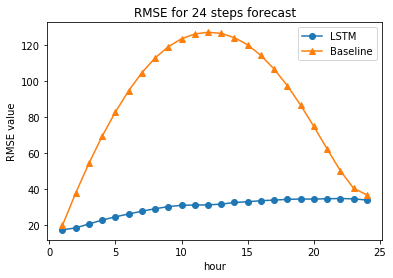

In [152]:
hours = list(range(1,25)) 
plt.plot(hours, rmse_lstm_m,  marker='o',label='LSTM')
plt.plot(hours, rmse_nf_m,  marker='^', label= 'Baseline')
plt.title("RMSE for 24 steps forecast")
plt.xlabel("hour")
plt.ylabel("RMSE value")
plt.legend()
plt.show()

### Compared to the baseline naive forecast model, LSTM still does a good job in multistep forecasting. As we can see, along with the time, RMSE increases. For the model it is more difficult to predict long future than the short future data. 